<a href="https://colab.research.google.com/github/shahsamir24/Brain-tumor-Project/blob/main/Resnet_50_d2_w_d1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip '/content/drive/MyDrive/d2 with d1.zip'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from tqdm import tqdm
from warnings import filterwarnings
import pickle
import os
import shutil
import random
import cv2

#Import sklearn modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

#Import tf modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
train_img = []
train_labels_not_encoded = []

test_img = []
test_labels_not_encoded = []

path_train = '/content/d2 with d1/Training/'  # Update the path to the Training directory in session storage
path_test = '/content/d2 with d1/Testing/'  # Update the path to the Testing directory in session storage

img_size = 180
for i in os.listdir(path_train):
    for j in tqdm(os.listdir(path_train + i)):
        train_img.append(cv2.resize(cv2.imread(path_train + i + '/' + j), (img_size, img_size)))
        train_labels_not_encoded.append(i)

for i in os.listdir(path_test):
    for j in tqdm(os.listdir(path_test + i)):
        test_img.append(cv2.resize(cv2.imread(path_test + i + '/' + j), (img_size, img_size)))
        test_labels_not_encoded.append(i)

train_img = np.array(train_img)
test_img = np.array(test_img)

100%|██████████| 150/150 [00:00<00:00, 235.03it/s]


In [ ]:
y_train = pd.get_dummies(train_labels_not_encoded)
y_test = pd.get_dummies(test_labels_not_encoded)
labels=y_train.columns

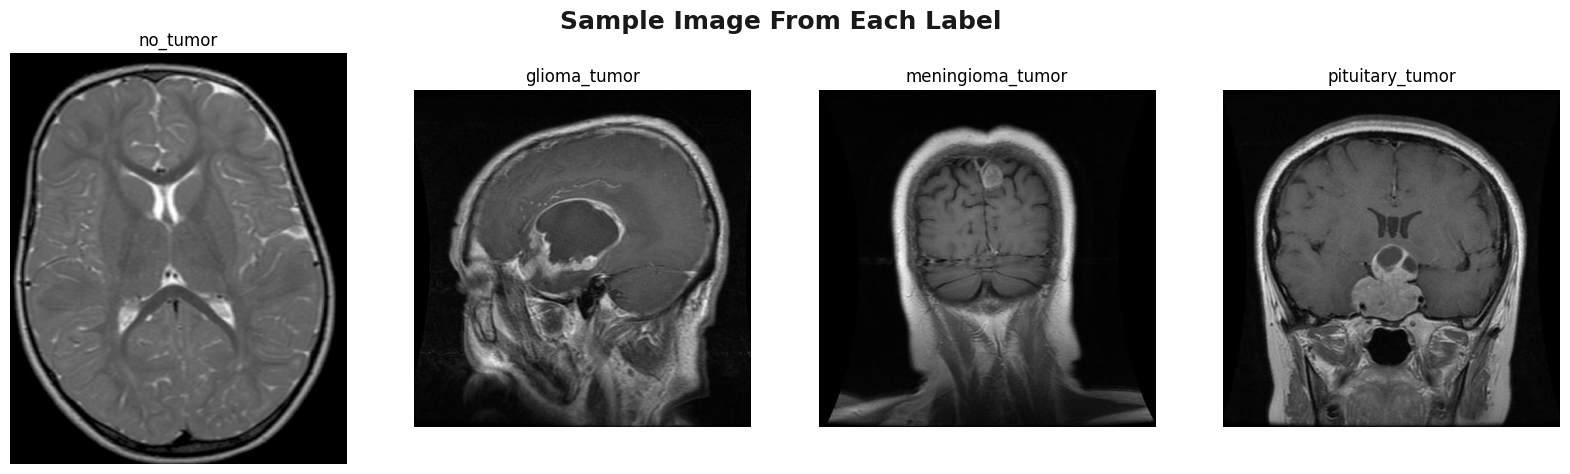

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
         color="black",y=0.61,x=0.4,alpha=0.9)
for count, ele in enumerate(os.listdir(path_train)):
    for j in os.listdir(path_train+ele):
        img= cv2.imread(path_train+ele+'/'+j)
        ax[count].imshow(img)
        ax[count].set_title(ele)
        ax[count].axis('off')
        break

In [ ]:
print("Train size:", train_img.shape[0], "Test size:", test_img.shape[0])

Train size: 3526 Test size: 599


In [ ]:
y_train

,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
3521,False,False,False,True
3522,False,False,False,True
3523,False,False,False,True
3524,False,False,False,True


In [ ]:
def clear_previous_calculations():
    try:
        shutil.rmtree("logs")
    except Exception as e:
        pass

    for i in ["tumor_model.h5", "predictions.pkl"]:
        try:
            os.remove(i)
        except Exception as e:
            pass

In [ ]:
def get_model():
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size, img_size, 3)),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.1)
    ])
    resnet = InceptionResNetV2(include_top=False, input_shape=(img_size, img_size, 3))
    model = Sequential([
        data_augmentation,
        resnet,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(rate=0.4),
        layers.Dense(4, activation='softmax')
    ])
    return model


In [ ]:
def get_callbacks():
    tensorboard = TensorBoard(log_dir = 'logs', histogram_freq=1)
    checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2,
                                  mode='auto',verbose=1, min_lr=0.000001)
    return [tensorboard,checkpoint,reduce_lr]

In [ ]:
def get_fig_and_axes_list(plot_count,column_number=2):
    """
    This function takes in the number of subplots to be plotted and the desired number of columns for the subplot grid.
    It then calculates the number of rows required and generates a matplotlib figure with the given number of subplots
    in a grid with the desired number of columns.

    Args:
    - plot_count: int, the number of subplots to be plotted
    - column_number: int, the number of columns in the subplot grid. Default value is 2.

    Returns:
    - fig: matplotlib Figure object, the generated figure
    - axes_list: list of matplotlib Axes objects, the axes of the subplots in the figure
    """
    reminder_num = plot_count % column_number
    row_num = (plot_count // column_number) + (reminder_num > 0)
    axes_list = []
    row_number_alignment = np.ones((row_num, column_number), dtype="int")
    if reminder_num != 0:
        row_number_alignment[-1,-(column_number - reminder_num):] = 0
    coefficient = (3.5 if plot_count==1 else 5.2)
    col_size = coefficient*column_number
    row_size = coefficient*row_num
    fig = plt.figure(figsize=(col_size, row_size), layout="constrained")
    spec = fig.add_gridspec(row_num, column_number)
    for i in range(row_number_alignment.shape[0]):
        for j in range(row_number_alignment.shape[1]):
            if row_number_alignment[i,j] == 1:
                ax = fig.add_subplot(spec[i,j])
                axes_list.append(ax)
    return fig,axes_list

In [ ]:
def get_axes_list(length, column_number=2):
    fig, axes_list = get_fig_and_axes_list(length, column_number=column_number )
    return axes_list

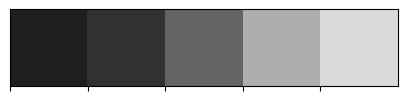

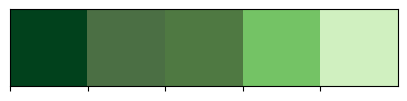

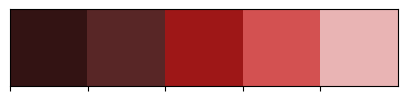

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #Supress warnings
clear_previous_calculations()
model = get_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 6148      
                                                                 
Total params: 54342884 (207.30 MB)
Trainable params: 5

In [ ]:
epochs = 20
batch_size=32
all_callbacks = get_callbacks()
history = model.fit(train_img, y_train, validation_split=0.1,  epochs=epochs, batch_size=batch_size,
                    callbacks=all_callbacks,  shuffle=True, verbose=1, workers=1)
model.load_weights('effnet.h5')

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.8361
Epoch 1: val_accuracy improved from -inf to 0.09632, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 167s 793ms/step - loss: 0.4735 - accuracy: 0.8361 - val_loss: 1.7571 - val_accuracy: 0.0963 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.9007
Epoch 2: val_accuracy did not improve from 0.09632
100/100 [==============================] - 52s 525ms/step - loss: 0.2764 - accuracy: 0.9007 - val_loss: 3.1680 - val_accuracy: 0.0737 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9259
Epoch 3: val_accuracy improved from 0.09632 to 0.75071, saving model to effnet.h5
100/100 [==============================] - 69s 693ms/step - loss: 0.2069 - accuracy: 0.9259 - val_loss: 0.8604 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9430
Epoch 4: val_accuracy improved from 0.75071 to 0.84136, saving model to effnet.h5
100/100 [==============================] - 67s 669ms/st

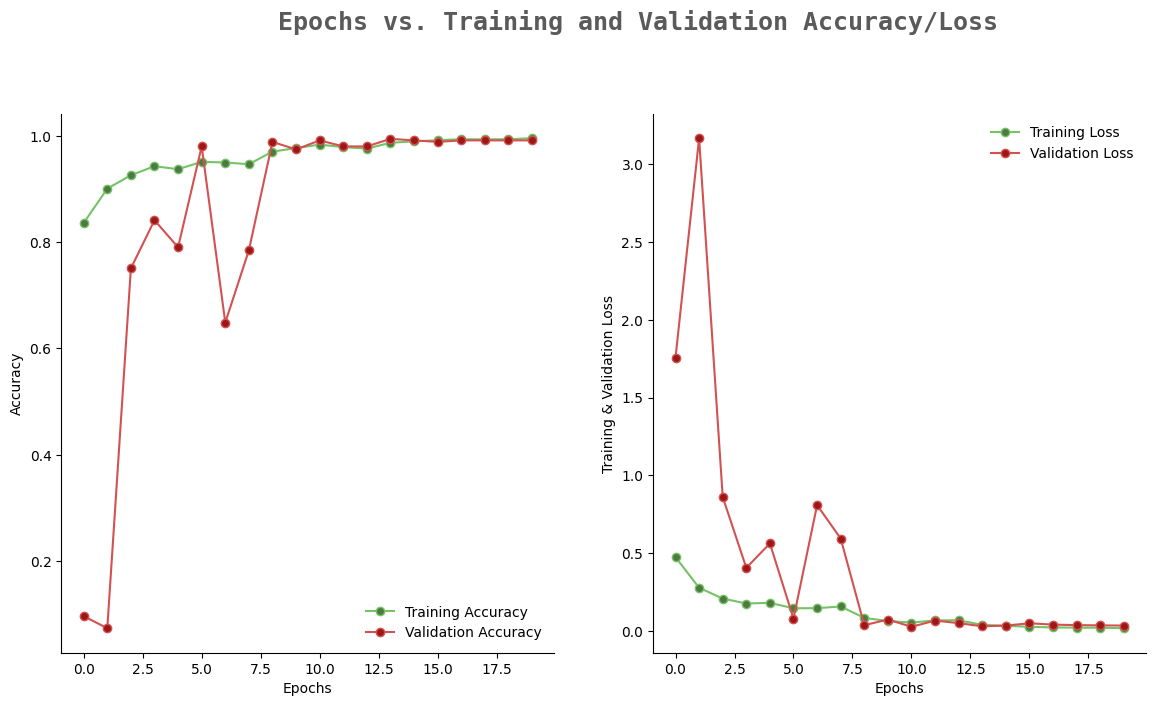

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_count = [i for i in range(len(train_acc))]

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs_count, train_acc, marker='o',markerfacecolor=colors_green[2], color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs_count, val_acc, marker='o',markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs_count, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs_count, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred_prob = model.predict(test_img)
pred = np.argmax(pred_prob,axis=1)
y_test_encoded = np.argmax(y_test.to_numpy(),axis=1)
y_train_encoded = np.argmax(y_train.to_numpy(),axis=1)
train_pred_proba = model.predict(train_img)
train_pred = np.argmax(train_pred_proba,axis=1)

111/111 [==============================] - 11s 104ms/step


In [ ]:
boosting_model = GradientBoostingClassifier()
boosting_model.fit(train_pred_proba,  y_train_encoded)
meta_test = boosting_model.predict(pred_prob)


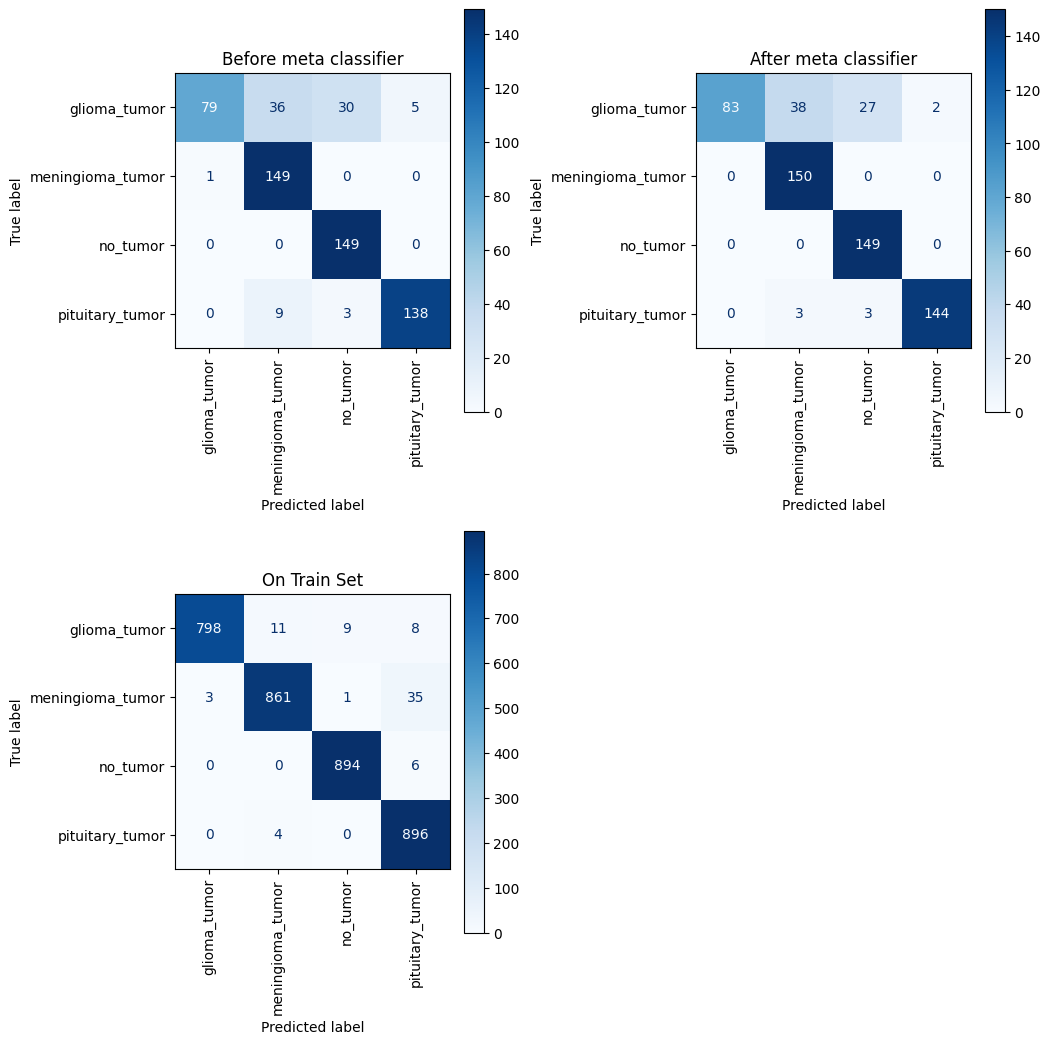

In [ ]:
axes = get_axes_list(3)

axes[0].set_title("Before meta classifier")
ConfusionMatrixDisplay.from_predictions(y_test_encoded, pred, display_labels=labels,
                                        cmap='Blues', ax=axes[0], xticks_rotation="vertical")

axes[1].set_title("After meta classifier")
ConfusionMatrixDisplay.from_predictions(y_test_encoded, meta_test, display_labels=labels,
                                        cmap='Blues', ax=axes[1], xticks_rotation="vertical")

axes[2].set_title("On Train Set")
ConfusionMatrixDisplay.from_predictions(y_train_encoded, train_pred, display_labels=labels,
                                        cmap='Blues', ax=axes[2], xticks_rotation="vertical")

In [ ]:
before = roc_auc_score(y_test, pred_prob,multi_class="ovo")
print("Before meta classifier:\n", classification_report(y_test_encoded,pred),"\n RUC-AUC:", before)

Before meta classifier:
               precision    recall  f1-score   support

           0       0.99      0.53      0.69       150
           1       0.77      0.99      0.87       150
           2       0.82      1.00      0.90       149
           3       0.97      0.92      0.94       150

    accuracy                           0.86       599
   macro avg       0.88      0.86      0.85       599
weighted avg       0.88      0.86      0.85       599
 
 RUC-AUC: 0.9639483673221959


In [ ]:
after = roc_auc_score(y_test, boosting_model.predict_proba(pred_prob),multi_class="ovo")
print("After meta classifier:\n", classification_report(y_test_encoded, meta_test),"\n RUC-AUC:", after)

After meta classifier:
               precision    recall  f1-score   support

           0       1.00      0.55      0.71       150
           1       0.79      1.00      0.88       150
           2       0.83      1.00      0.91       149
           3       0.99      0.96      0.97       150

    accuracy                           0.88       599
   macro avg       0.90      0.88      0.87       599
weighted avg       0.90      0.88      0.87       599
 
 RUC-AUC: 0.9577428256345611


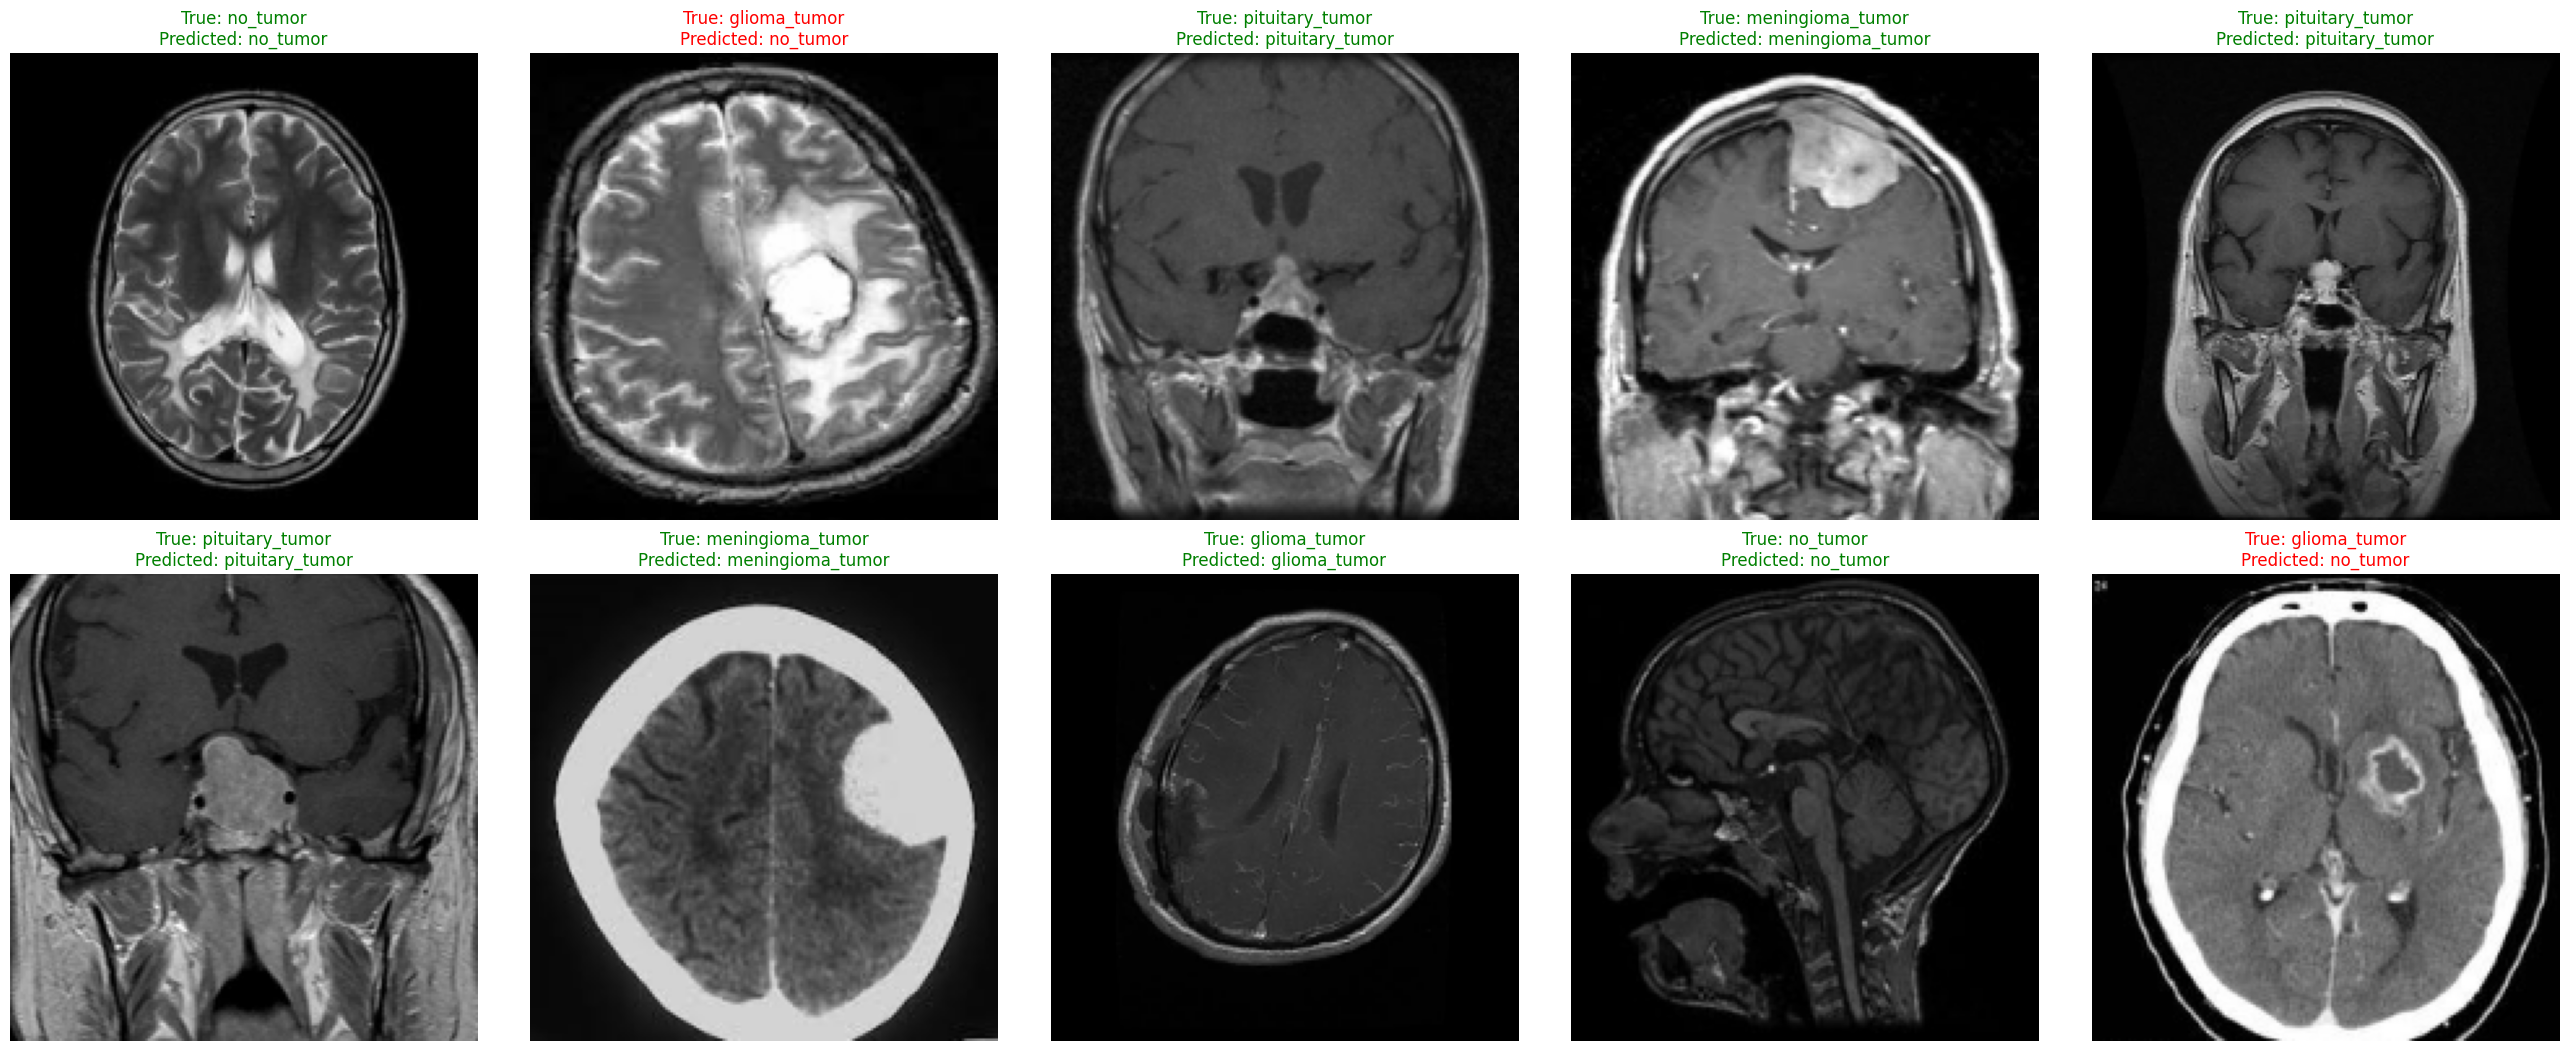

In [ ]:
fig,ax_list = get_fig_and_axes_list(10,5)
random_image_index = np.random.randint(test_img.shape[0], size=10)
for count, ele in enumerate(random_image_index):
    ax_list[count]
    ax_list[count].imshow(test_img[ele])
    color = ("green" if pred[ele] == y_test_encoded[ele] else "red")
    ax_list[count].set_title(f"True: {test_labels_not_encoded[ele]}\nPredicted: { labels[pred[ele]] }", color=color)
    ax_list[count].axis('off')